<a href="https://colab.research.google.com/github/ronincodex/Student-Engagement-and-Performance-SOM/blob/main/Multiclass_Engagement_and_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sn

from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
import os
print(os.getcwd())

/content


# Load the Dataset

In [3]:
# Engagement Data Set
data_engagement = "Student_Engagement_Multiclass.csv"
data_performance = "Student_performance_Multiclass.csv"

# Performance

# Read Data

In [6]:
data_performance = pd.read_csv('/content/sample_data/Student_Performance_Multiclass.csv')
data_performance = data_performance.drop(["Student ID"],axis=1)
data_performance.head(30)

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class
0,95,91,70,90,84,64,85,85,G
1,85,76,65,61,73,64,76,76,G
2,85,41,73,61,73,61,73,73,G
3,80,78,80,79,79,57,80,79,G
4,85,91,78,80,84,67,85,85,G
5,80,79,83,87,82,60,83,83,G
6,70,91,80,81,79,73,85,85,G
7,75,65,63,71,78,31,64,64,F
8,80,87,85,88,89,59,85,85,G
9,70,68,85,91,82,71,86,86,G


# Check For Missing Values

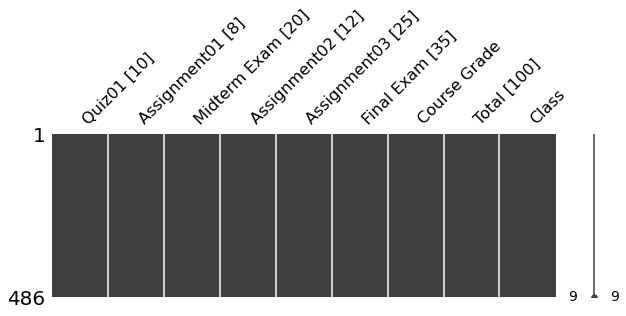

In [7]:
msno.matrix(data_performance,figsize=(10,3))


# Corelation Between Features

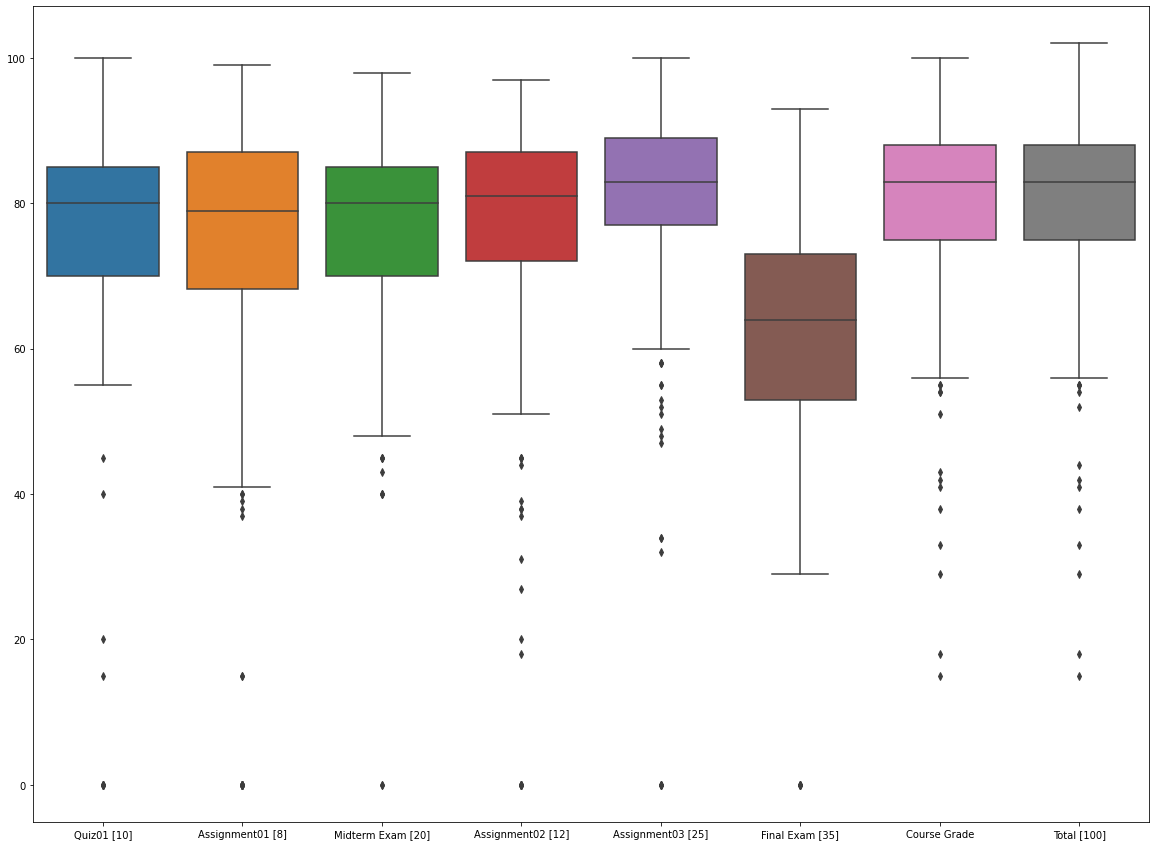

In [8]:
continiousData = data_performance.iloc[:,:-1]
continiousData.head()

fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(20, 15)
sn.boxplot(data=continiousData,orient="v",ax=axes)

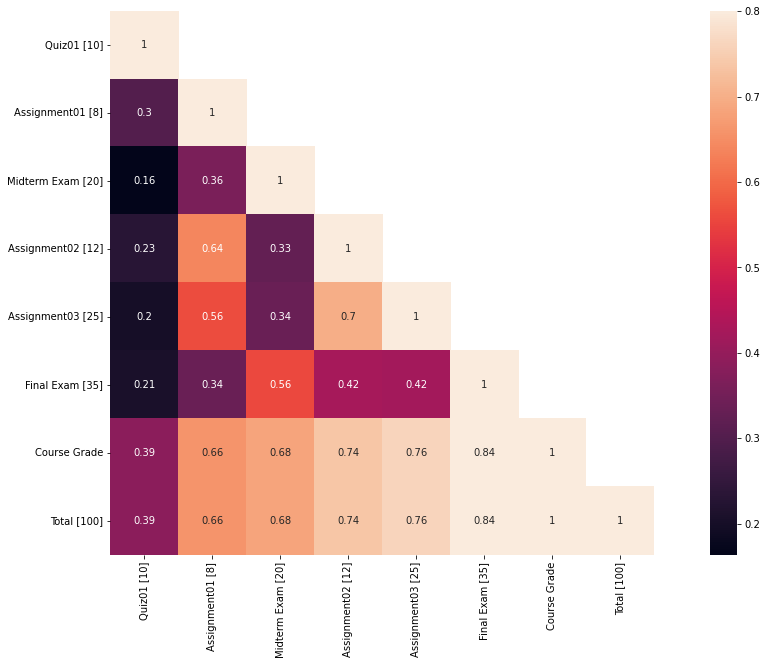

In [9]:
# Correlation analysis
corrMatt = data_performance.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

# Normalization

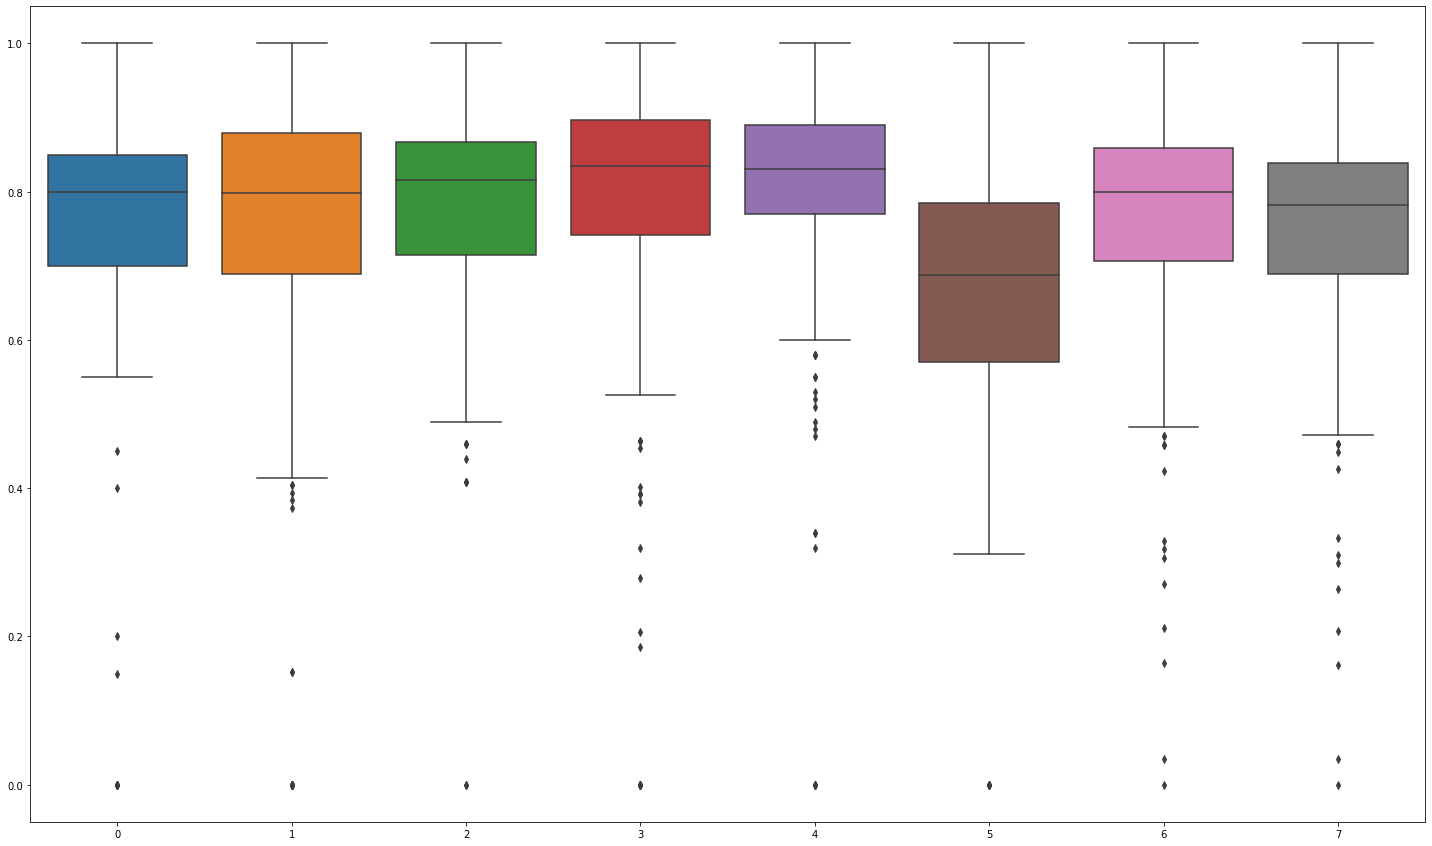

In [10]:
# normalization
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

normalized_performance=minmax_scaler(data_performance.iloc[:,:-1])
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(25, 15)
sn.boxplot(data=normalized_performance,orient="v",ax=axes)

# Unsupervised Learning Via SOM

In [11]:
## SOM

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
print(tf.__version__)

class SOM(object): 
  
  #Initialize properties
  def __init__(self, x, y, input_dim, learning_rate, radius, num_iter=500):
    self._x = x
    self._y = y
    self._learning_rate = float(learning_rate)
    self._radius = float(radius)
    self._num_iter = num_iter
    self._graph = tf.Graph()

    #Initialize graph
    with self._graph.as_default():

        #Initializing variables and placeholders
        self._weights = tf.Variable(tf.random_normal([x*y, input_dim]))
        self._locations = self._generate_index_matrix(x, y)
        self._input = tf.placeholder("float", [input_dim])
        self._iter_input = tf.placeholder("float")

        #Calculating BMU
        input_matix = tf.stack([self._input for i in range(x*y)])
        distances = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self._weights, input_matix), 2), 1))
        bmu = tf.argmin(distances, 0)

        #Get BMU location
        mask = tf.pad(tf.reshape(bmu, [1]), np.array([[0, 1]]))
        size = tf.cast(tf.constant(np.array([1, 2])), dtype=tf.int64)
        bmu_location = tf.reshape(tf.slice(self._locations, mask, size), [2])

        #Calculate learning rate and radius
        decay_function = tf.subtract(1.0, tf.div(self._iter_input, self._num_iter))
        _current_learning_rate = tf.multiply(self._learning_rate, decay_function)
        _current_radius = tf.multiply(self._radius, decay_function)

        #Adapt learning rate to each neuron based on position
        bmu_matrix = tf.stack([bmu_location for i in range(x*y)])
        bmu_distance = tf.reduce_sum(tf.pow(tf.subtract(self._locations, bmu_matrix), 2), 1)
        neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance, "float32"), tf.pow(_current_radius, 2))))
        learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)

        #Update all the weights
        multiplytiplier = tf.stack([tf.tile(tf.slice(
            learning_rate_matrix, np.array([i]), np.array([1])), [input_dim])
                                           for i in range(x*y)])
        delta = tf.multiply(
            multiplytiplier,
            tf.subtract(tf.stack([self._input for i in range(x*y)]), self._weights))                

        new_weights = tf.add(self._weights, delta)
        self._training = tf.assign(self._weights, new_weights)                                       

        #Initilize session and run it
        self._sess = tf.Session()
        initialization = tf.global_variables_initializer()
        self._sess.run(initialization)

  def train(self, input_vects):
      for iter_no in range(self._num_iter):
          for input_vect in input_vects:
              self._sess.run(self._training,
                            feed_dict={self._input: input_vect,
                                        self._iter_input: iter_no})

      self._centroid_matrix = [[] for i in range(self._x)]
      self._weights_list = list(self._sess.run(self._weights))
      self._locations = list(self._sess.run(self._locations))
      for i, loc in enumerate(self._locations):
          self._centroid_matrix[loc[0]].append(self._weights_list[i])

  def map_input(self, input_vectors):
      return_value = []
      for vect in input_vectors:
          min_index = min([i for i in range(len(self._weights_list))],
                          key=lambda x: np.linalg.norm(vect - self._weights_list[x]))
          return_value.append(self._locations[min_index])
      return return_value

  def _generate_index_matrix(self, x,y):
      return tf.constant(np.array(list(self._iterator(x, y))))

  def _iterator(self, x, y):
      for i in range(x):
          for j in range(y):
              yield np.array([i, j])

Instructions for updating:
non-resource variables are not supported in the long term


2.9.2


In [14]:
som = SOM(x = 3, y = 1, input_dim=8, learning_rate=0.5, num_iter = 500, radius = 1.0)
som.train(normalized_performance);

In [15]:
# print(som._weights_list)
print(som._locations)
cluster_centers_df = pd.DataFrame(data=som._weights_list,columns=data_performance.iloc[:,:-1].columns)
cluster_centers_df.head()

[array([0, 0]), array([1, 0]), array([2, 0])]


,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100]
0,0.799936,0.834117,0.844867,0.856730,0.859262,0.753776,0.847639,0.829257
1,0.761730,0.680014,0.696766,0.742449,0.757943,0.541557,0.667978,0.653723
2,0.562157,0.244644,0.629243,0.205586,0.431302,0.409161,0.367956,0.362161


In [29]:
cluster_assignment = som.map_input(normalized_performance)
data_performance["cluster_som"] = cluster_assignment
data_performance["cluster"] = data_performance.apply(lambda x: "weak" if x["cluster_som"][0]==1  else "good",axis=1)
#lambda <args> : <statement1> if <condition > ( <statement2> if <condition> else <statement3>)
data_performance = data_performance.drop(['cluster_som'],axis=1)
data_performance.head(5)

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class,cluster
0,95,91,70,90,84,64,85,85,G,good
1,85,76,65,61,73,64,76,76,G,weak
2,85,41,73,61,73,61,73,73,G,weak
3,80,78,80,79,79,57,80,79,G,good
4,85,91,78,80,84,67,85,85,G,good


In [31]:
data_performance_raw = pd.read_csv('/content/sample_data/Student_Performance_Multiclass.csv')
data_performance['student id'] = data_performance_raw['Student ID']

data_performance.head()

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class,cluster,student id
0,95,91,70,90,84,64,85,85,G,good,student000000
1,85,76,65,61,73,64,76,76,G,weak,student000001
2,85,41,73,61,73,61,73,73,G,weak,student000002
3,80,78,80,79,79,57,80,79,G,good,student000003
4,85,91,78,80,84,67,85,85,G,good,student000004


In [32]:
data_performance.groupby("cluster").count()
# data_performance.describe()

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class,student id
cluster,,,,,,,,,,
good,322,322,322,322,322,322,322,322,322,322
weak,164,164,164,164,164,164,164,164,164,164
